# 1. Import required libraries

In [1]:
#import the reqired libraries
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline
import gzip
import pandas as pd
from urllib.request import urlopen
import joblib

#Load dataset

In [2]:
### load the meta data
 
data = []
with gzip.open('C:\\Users\\POOJAANAND\\Documents\\Pulse\\Recommendation\\All_Beauty.json.gz') as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# total length of list, this number equals total number of products
print(len(data))
 
# first row of the list
print(data[0])

371345
{'overall': 1.0, 'verified': True, 'reviewTime': '02 19, 2015', 'reviewerID': 'A1V6B6TNIC10QE', 'asin': '0143026860', 'reviewerName': 'theodore j bigham', 'reviewText': 'great', 'summary': 'One Star', 'unixReviewTime': 1424304000}


In [3]:

electronics_df= pd.DataFrame.from_dict(data)

In [4]:
#naming the columns
electronics_df.rename(columns = {'overall':'Rating', 'asin':'ProductId',
                              'reviewTime':'Timestamp', 'reviewerID': 'UserId'}, inplace = True)

# 2. Load the dataset and add headers

In [5]:
electronics_df =electronics_df [['Rating','ProductId','UserId', 'Timestamp' ]]

In [6]:
electronics_df.head()

,Rating,ProductId,UserId,Timestamp
0,1.0,0143026860,A1V6B6TNIC10QE,"02 19, 2015"
1,4.0,0143026860,A2F5GHSXFQ0W6J,"12 18, 2014"
2,4.0,0143026860,A1572GUYS7DGSR,"08 10, 2014"
3,5.0,0143026860,A1PSGLFK1NSVO,"03 11, 2013"
4,5.0,0143026860,A6IKXKZMTKGSC,"12 25, 2011"


In [7]:
#electronics_df.drop('Timestamp',axis=1,inplace=True)

In [8]:
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 371345 entries, 0 to 371344
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Rating     371345 non-null  float64
 1   ProductId  371345 non-null  object 
 2   UserId     371345 non-null  object 
 3   Timestamp  371345 non-null  object 
dtypes: float64(1), object(3)
memory usage: 11.3+ MB


In [9]:
rows, columns= electronics_df.shape
print("No. of rows: " ,rows)
print("No. of columns: " ,columns)


No. of rows:  371345
No. of columns:  4


In [10]:
#Check the datatypes
electronics_df.dtypes

Rating       float64
ProductId     object
UserId        object
Timestamp     object
dtype: object

# 3. Subsetting dataset

In [11]:
#Taking subset of the dataset
electronics_df1= electronics_df.iloc[:130000,0:]

In [42]:
#df2 = df1[df1['year'] >= 2016]

Either way to subset data based on rows or take year..her I have taken half of the dataset 

In [12]:
electronics_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130000 entries, 0 to 129999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Rating     130000 non-null  float64
 1   ProductId  130000 non-null  object 
 2   UserId     130000 non-null  object 
 3   Timestamp  130000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 4.0+ MB


In [13]:
#Summary statistics of rating variable
electronics_df1['Rating'].describe().T

count    130000.000000
mean          4.265669
std           1.232868
min           1.000000
25%           4.000000
50%           5.000000
75%           5.000000
max           5.000000
Name: Rating, dtype: float64

In [14]:
#Find the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df1.Rating.min()))
print('Maximum rating is: %d' %(electronics_df1.Rating.max()))

Minimum rating is: 1
Maximum rating is: 5


Handling Missing values

In [15]:
#Check for missing values
print('Number of missing values across columns: \n',electronics_df1.isnull().sum())

Number of missing values across columns: 
 Rating       0
ProductId    0
UserId       0
Timestamp    0
dtype: int64


Data contains no missing values

create new columns from timestamp to find some trends

In [23]:
electronics_df1['Timestamp'] = pd.to_datetime(electronics_df1['Timestamp'], infer_datetime_format=True)

In [24]:


electronics_df1["day"] = electronics_df1['Timestamp'].map(lambda x: x.day)
electronics_df1["month"] = electronics_df1['Timestamp'].map(lambda x: x.month)
electronics_df1["year"] = electronics_df1['Timestamp'].map(lambda x: x.year)

find duplicate values

In [25]:
#duplicate= electronics_df1.drop_duplicates(['ProductId','UserId']).reset_index()

#print("Duplicate Rows :")
  
# Print the resultant Dataframe
#duplicate

Duplicate Rows :


,index,Rating,ProductId,UserId,Timestamp,month,year
0,0,1,0143026860,A1V6B6TNIC10QE,2015-02-19,2,2015
1,1,4,0143026860,A2F5GHSXFQ0W6J,2014-12-18,12,2014
2,2,4,0143026860,A1572GUYS7DGSR,2014-08-10,8,2014
3,3,5,0143026860,A1PSGLFK1NSVO,2013-03-11,3,2013
4,4,5,0143026860,A6IKXKZMTKGSC,2011-12-25,12,2011
...,...,...,...,...,...,...,...
121046,129995,3,B000FOI48G,A3SZ2C5L0Q65BW,2014-09-20,9,2014
121047,129996,5,B000FOI48G,A2T060YFG0A8WU,2014-09-20,9,2014
121048,129997,5,B000FOI48G,A5JCD012ZPYOT,2014-09-20,9,2014
121049,129998,5,B000FOI48G,A1INA0F5CWW3J4,2014-09-20,9,2014


Group by values using product id and user Id and find the top 10 unique products which are reviewed the most

In [28]:
# Number of unique user id  in the data
uniq_usr = print('Number of unique users in Raw data = ', electronics_df1['UserId'].nunique())
# Number of unique product id  in the data
uniq_prod = print('Number of unique product in Raw data = ', electronics_df1['ProductId'].nunique())

Number of unique users in Raw data =  110381
Number of unique product in Raw data =  1359


There are None unique products. The TOP 10 products are:
ProductId
B000GLRREU    8331
1620213982    4781
B001QY8QXM    4495
B006IB5T4W    2779
B000FOI48G    2505
B00005JS5C    2239
B0067F28ZW    1840
B000050FDY    1528
B000FED5DU    1319
B001AJ6YS2    1317
Name: UserId, dtype: int64

TOP 10 products covers 23.9 percent of all the orders.


<Figure size 1152x576 with 0 Axes>

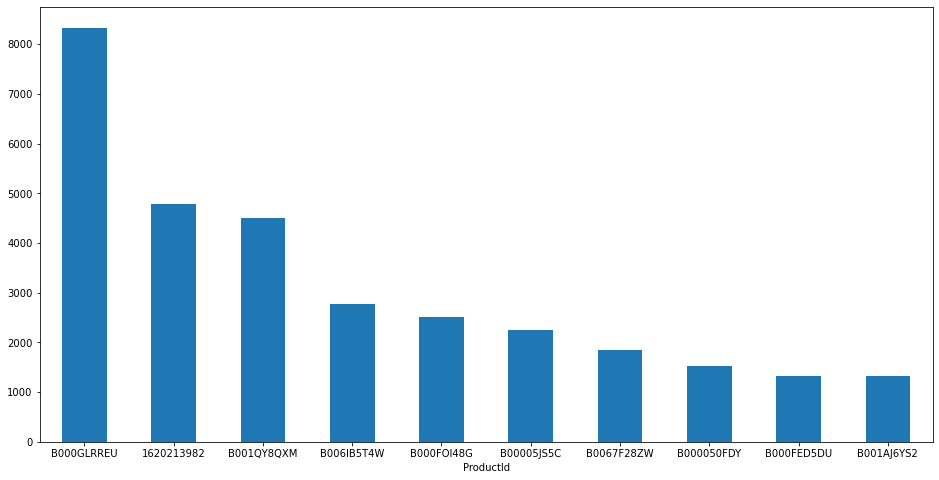

In [30]:
prod_df1 = electronics_df1.groupby('ProductId')['UserId'].nunique().sort_values(ascending=False)
print("There are",uniq_prod,"unique products. The TOP 10 products are:")
prod_final = prod_df1.head(10)
print(prod_final)
print("\nTOP 10 products covers", round(prod_final.sum()/electronics_df1.shape[0]*100,1),"percent of all the orders.")
plt.figure(figsize=(16,8))
prod_final.plot(kind="bar",rot=0)

#Group by values using product id and user Id and find the top 10 unique users who have reviewed the most products

There are None unique products. The TOP 10 users are:
UserId
AJGU56YG8G1DQ     10
A2V1J3JT5OOZFO     7
A22CW0ZHY3NJH8     7
AENH50GW3OKDA      6
A2JOBUCXKEXYY8     6
ABPNZ9RKXOP0E      6
A2LAS014NSRW72     6
A2VOGNBUMXSW13     6
A2PF64RBR1G1SZ     6
A1XQ0F01CF84Y3     6
Name: ProductId, dtype: int64

TOP 10 users covers 0.1 percent of all the reviews.


<Figure size 1152x576 with 0 Axes>

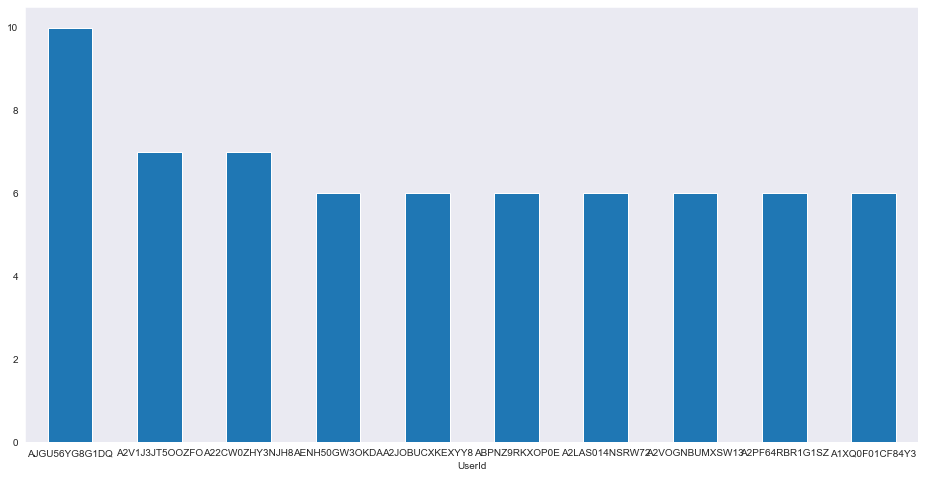

In [73]:
usr_df1 = electronics_df1.groupby('UserId')['ProductId'].nunique().sort_values(ascending=False)

print("There are",uniq_usr,"unique products. The TOP 10 users are:")
usr_final = usr_df1.head(10)
print(usr_final)
print("\nTOP 10 users covers", round(usr_final.sum()/electronics_df1.shape[0]*100,1),"percent of all the reviews.")
plt.figure(figsize=(16,8))
usr_final.plot(kind="bar",rot=0)

find which years have the most frequency of distribution of data. The graph shows most of the users have reviewed the products between 2013 to 2018, with a max peak at 2016

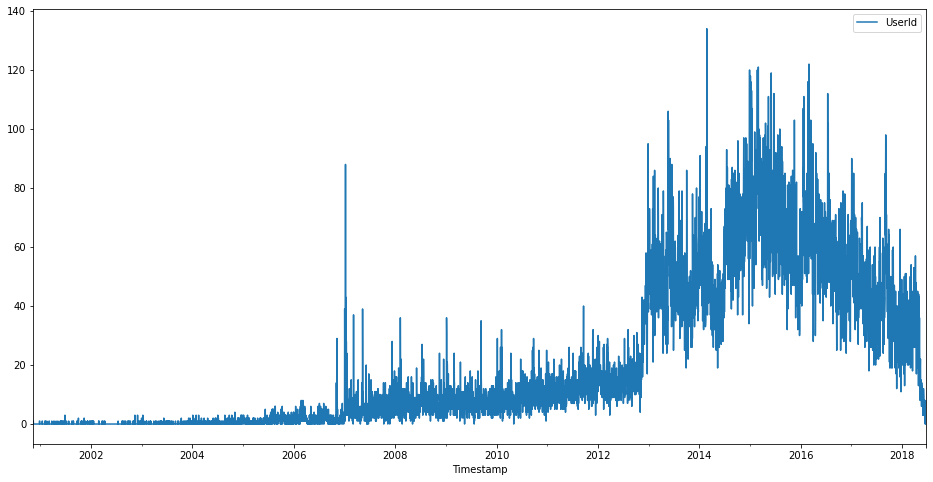

In [34]:
counts = electronics_df1.set_index("Timestamp").groupby(pd.Grouper(freq='D')).count()
fig = plt.figure(figsize=(16,8))
ax = fig.gca()
counts.plot(y = "UserId", use_index=True, ax=ax)

Histogram to find the distribution of data

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025C2408D4C0>],
      dtype=object)

Text(0.5, 0, 'Number of Ratings')

Text(0, 0.5, 'Counts')

Text(0.5, 1.0, 'Histogram of Ratings count')

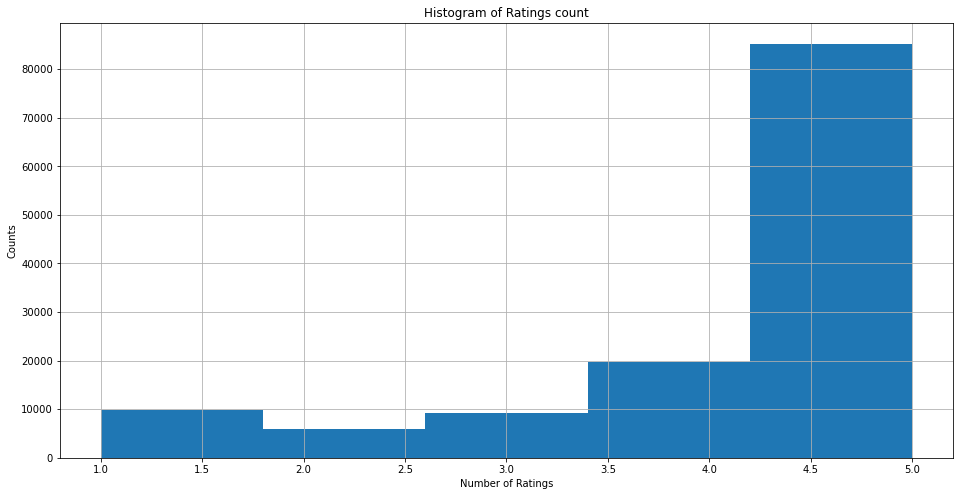

In [36]:
fig, ax = plt.subplots(figsize=(16,8))
electronics_df1.hist(column = "Rating", bins = electronics_df1["Rating"].max(), ax=ax)
plt.xlabel("Number of Ratings")
plt.ylabel("Counts")
plt.title("Histogram of Ratings count")

In [39]:
# Find the no of products reviewed and the unique no of customers placed orders, of each product
freq_items_df = electronics_df1.groupby(['ProductId', 'UserId']).agg({'day':'count'})
freq_items_df.columns=['No_of_Products_by_user']

# Reset the index by converting the ProductId and UserID into columns
freq_items_df.reset_index(inplace=True)


# Products with high no of orders are considered as most frequently purchased items

# Rank the product by No of Products, at user Level

ord_count_col = freq_items_df['No_of_Products_by_user'].astype(str)
freq_items_df['Review_Rank'] = (ord_count_col).rank(method='min',ascending=False).astype(int)


# List of top 20 most popular items reviewed
freq_items_final=freq_items_df.sort_values('Review_Rank',ascending=True).head(50)
freq_items_final.head()

,ProductId,UserId,No_of_Products_by_user,Review_Rank
111828,B007V6JNE0,AKJHHD5VEH7VG,9,1
20279,B0006O10P4,A3E5V5TSTAY3R9,5,2
53746,B000VUXCGI,A1UT1Q85F0105C,4,3
59511,B0012Y0ZG2,A2VABJ7S3OTH4K,4,3
53807,B000VV1YOY,A15M85BJP45XSZ,4,3


 Ratings

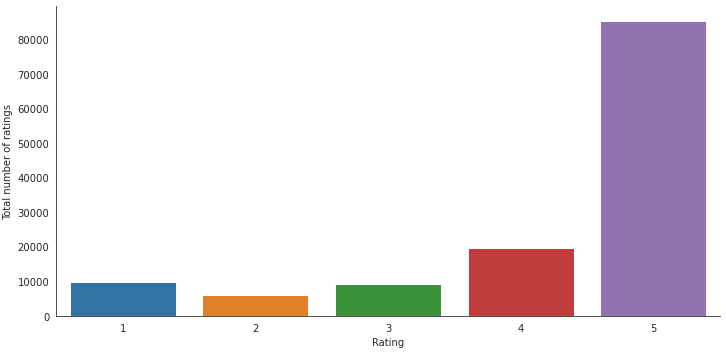

In [40]:
# Check the distribution of the rating
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data=electronics_df1, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

Users and products

Average rating of each UserId

In [43]:
#now let's take a look at the average rating of each product Id. 
electronics_df1.groupby('UserId')['Rating'].mean().sort_values(ascending=False).head()

UserId
A0096681Y127OL1H8W3U    5.0
A38KV68M422TQJ          5.0
A38LIYW224XKV           5.0
A38L9JPKG0G1VY          5.0
A38L9DMCXCI0A9          5.0
Name: Rating, dtype: float64

In [45]:
electronics_df1.groupby('UserId')['Rating'].count().sort_values(ascending=False).head()

UserId
A1XQ0F01CF84Y3    12
AJGU56YG8G1DQ     11
A3HHQ7UIJJAOAV    11
AKJHHD5VEH7VG     11
A3RUBIOZYJNY0D    10
Name: Rating, dtype: int64

As mean is not a good indicator because a product can show in the list as the top renowned product if a single user has given the highest rating. So we need to look into count rather than mean. We can see total number of ratings for a product below

In [46]:
electronics_df1.groupby('ProductId')['Rating'].count().sort_values(ascending=False).head()

ProductId
B000GLRREU    8331
1620213982    4782
B001QY8QXM    4534
B006IB5T4W    2780
B000FOI48G    2506
Name: Rating, dtype: int64

Creating a dataframe which contains both average and count of ratings

In [47]:
ratings_mean_count = pd.DataFrame(electronics_df1.groupby('ProductId')['Rating'].mean())

In [48]:
ratings_mean_count['rating_counts'] = pd.DataFrame(electronics_df1.groupby('ProductId')['Rating'].count())

Plot a histogram for the number of ratings represented by rating_counts And it shows the rating receieved is very less

<Figure size 576x432 with 0 Axes>

(0.0, 500.0, 0.0, 5000.0)

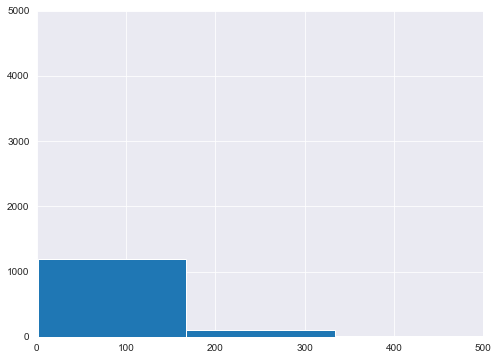

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
%matplotlib inline

plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True

ratings_mean_count['rating_counts'].hist(bins=50)

plt.axis([0, 500, 0, 5000])

Histogram of average ratings

The graph shows skewness towards Left.

<Figure size 576x432 with 0 Axes>

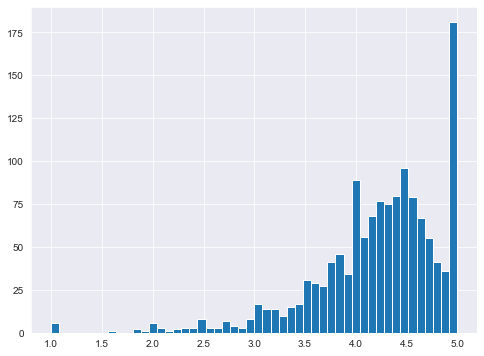

In [58]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

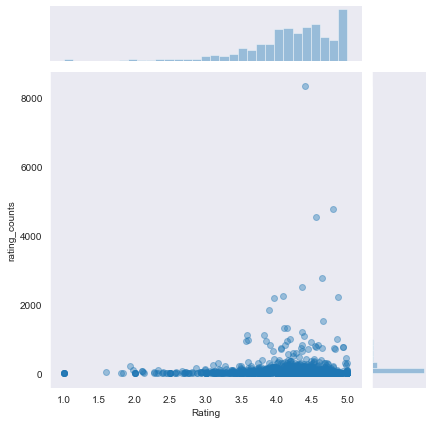

In [59]:
plt.figure(figsize=(10,10))

sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

products which have higher avg poduct rating have more number of product ratings compared to products with lower average rating

Correlation matrix between df1 dataset and ratings_mean_count as well

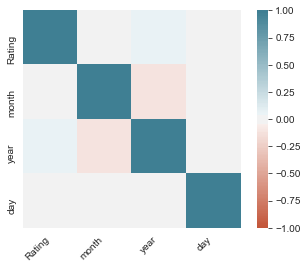

In [60]:
corr = electronics_df1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

top 10 products having avg rating more than 4.5 . The Pie chart below shows the top 10 products where all Product Id's have an average rating of 5

ProductId
B0045MA8S8    5.0
B002FCQAKA    5.0
B0039PGQ8I    5.0
B0039MZZCE    5.0
B0037QF6XU    5.0
Name: Rating, dtype: float64

,Rating
ProductId,
B0045MA8S8,5.0
B002FCQAKA,5.0
B0039PGQ8I,5.0
B0039MZZCE,5.0
B0037QF6XU,5.0
B003326Y34,5.0
B0031AXETA,5.0
B002T8Y7PU,5.0
B002SZZW8U,5.0


Text(0.5, 1.0, 'Top 10 products with Average Rating >4.5')

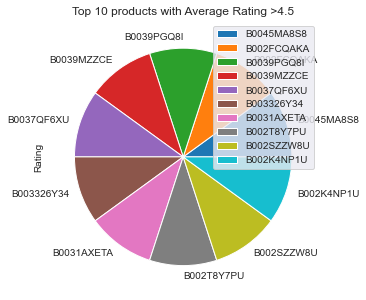

In [62]:
electronics_df1.groupby('ProductId')['Rating'].mean().sort_values(ascending= False).head()
max_ratings_mean= pd.DataFrame(electronics_df1.groupby('ProductId')['Rating'].mean().sort_values(ascending=False).head(10))

max_ratings_mean[max_ratings_mean['Rating']>4.5]
plot = max_ratings_mean.plot.pie(y='Rating', figsize=(5, 5))
plt.title("Top 10 products with Average Rating >4.5")

top 10 products having maximum number of rating more than 1000 . The Pie chart below shows the top 10 products where all Product Id's have maximum rating more than 1000.Thus the top 3 product ID are B0045MA8S8, B002FCQAKA and B0039PGQ8I

,Rating
ProductId,
B000GLRREU,8331
1620213982,4782
B001QY8QXM,4534
B006IB5T4W,2780
B000FOI48G,2506


            Rating
ProductId         
B000GLRREU    8331
1620213982    4782
B001QY8QXM    4534
B006IB5T4W    2780
B000FOI48G    2506
B00005JS5C    2239
B0012Y0ZG2    2224
B000WYJTZG    2180
B0067F28ZW    1840
B000050FDY    1528


Text(0.5, 1.0, 'Top 10 products with Number of Rating >1000')

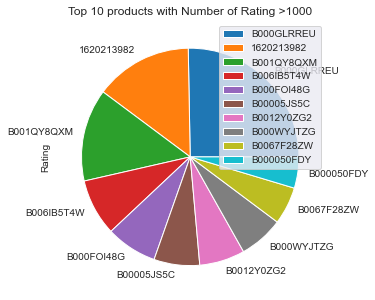

In [63]:
max_ratings_cnt= pd.DataFrame(electronics_df1.groupby('ProductId')['Rating'].count().sort_values(ascending=False).head(10))
max_ratings_cnt.head()
print(max_ratings_cnt[max_ratings_cnt['Rating']>1000])

plot1 = max_ratings_cnt.plot.pie(y='Rating', figsize=(5, 5))
plt.title("Top 10 products with Number of Rating >1000")

top 10 products having avg rating less than 1.5 . The Pie chart below shows the top 10 products where all Product Id's have an average rating of 1. The top 3 Product Id's are B000GLRREU, 1620213982 and B001QY8QXM

ProductId
B0055DXIPG    1.0
B00846O5SK    1.0
B009YDVB6Q    1.0
B0029L3ASM    1.0
B006LXC6NY    1.0
Name: Rating, dtype: float64

            Rating
ProductId         
B0055DXIPG     1.0
B00846O5SK     1.0
B009YDVB6Q     1.0
B0029L3ASM     1.0
B006LXC6NY     1.0
B000GG87SK     1.0


Text(0.5, 1.0, 'Top 10 products with Average Rating <1.5')

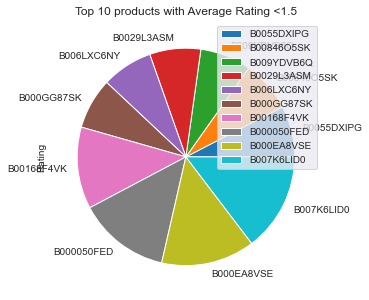

In [65]:
electronics_df1.groupby('ProductId')['Rating'].mean().sort_values(ascending= True).head()
min_ratings_mean= pd.DataFrame(electronics_df1.groupby('ProductId')['Rating'].mean().sort_values(ascending=True).head(10))

print(min_ratings_mean[min_ratings_mean['Rating']<1.5])
plot = min_ratings_mean.plot.pie(y='Rating', figsize=(5, 5))
plt.title("Top 10 products with Average Rating <1.5")

top 10 products having minimum number of rating less than 20 . The Pie chart below shows the top 10 products where all Product Id's have rating less than 20.Thus the top 3 product ID are B0055DXIPG, B00846O5SK and B009YDVB6Q

,Rating
ProductId,
B000GTG1YO,1
B0001HYJVS,1
B0001EL17Q,1
B0037QF6XU,1
B005VI0DSK,1


            Rating
ProductId         
B000GTG1YO       1
B0001HYJVS       1
B0001EL17Q       1
B0037QF6XU       1
B005VI0DSK       1
B00AITFCTC       1
B00AL6OBM6       1
B00AM4IVDC       1
B003OLXZN6       1
B004A8PGMK       1


Text(0.5, 1.0, 'Top 10 products with Number of Rating <20')

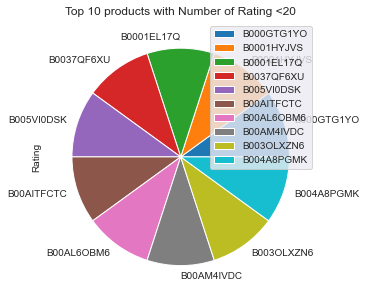

In [67]:
min_ratings_cnt= pd.DataFrame(electronics_df1.groupby('ProductId')['Rating'].count().sort_values(ascending=True).head(10))
min_ratings_cnt.head()
print(min_ratings_cnt[min_ratings_cnt['Rating']<20])

plot1 = min_ratings_cnt.plot.pie(y='Rating', figsize=(5, 5))
plt.title("Top 10 products with Number of Rating <20")

# 3. Taking the subset of dataset to make it less sparse/ denser.

In [70]:
#Check the top 10 users based on ratings
most_rated=electronics_df1.groupby('UserId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 UserId
A1XQ0F01CF84Y3    12
AJGU56YG8G1DQ     11
A3HHQ7UIJJAOAV    11
AKJHHD5VEH7VG     11
A3RUBIOZYJNY0D    10
A177B2VPWX4P55    10
A36LNAKD2FOHVX    10
A2GJX2KCUSR0EI     9
A3E5V5TSTAY3R9     8
A1L0QECT7J93ZP     8
dtype: int64


In [ ]:
counts=electronics_df1.UserId.value_counts()
electronics_df1_final=electronics_df1[electronics_df1.UserId.isin(counts[counts>=10].index)]
print('Number of users who have rated 15 or more items =', len(electronics_df1_final))
print('Number of unique users in the final data = ', electronics_df1_final['UserId'].nunique())
print('Number of unique products in the final data = ', electronics_df1_final['UserId'].nunique())

In [ ]:
electronics_df1_final

# Ratings analysis in final dataset

In [ ]:
final_ratings_matrix = electronics_df1_final.pivot_table(index='UserId', 
                        columns='ProductId', 
                        values='Rating').fillna(0)
final_ratings_matrix.columns.name = None
final_ratings_matrix

In [ ]:
#constructing the pivot table
#final_ratings_matrix = electronics_df1_final.pivot(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
#final_ratings_matrix.head()

In [ ]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

#4. Splitting the data

In [ ]:
#Split the data randomnly into train and test datasets into 70:30 ratio
train_data, test_data = train_test_split(electronics_df1_final, test_size = 0.3, random_state=0)
train_data.head()

In [ ]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

5. Building Popularity Recommder model

In [ ]:
#Count of user_id for each unique product as recommendation score 
train_data_grouped = train_data.groupby('ProductId').agg({'UserId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'UserId': 'score'},inplace=True)
train_data_grouped.head(40)

In [ ]:
#Sort the products on recommendation score 
train_data_sort = train_data_grouped.sort_values(['score', 'ProductId'], ascending = [0,1]) 
      
#Generate a recommendation rank based upon score 
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first') 
          
#Get the top 5 recommendations 
popularity_recommendations = train_data_sort.head(5) 
popularity_recommendations

In [ ]:
 #Use popularity based recommender model to make predictions
def recommend(user_id):     
    user_recommendations = popularity_recommendations 
          
    #Add user_id column for which the recommendations are being generated 
    user_recommendations['UserId'] = user_id 
      
    #Bring user_id column to the front 
    cols = user_recommendations.columns.tolist() 
    cols = cols[-1:] + cols[:-1] 
    user_recommendations = user_recommendations[cols] 
          
    return user_recommendations

In [ ]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))    
    print("\n") 

6. Building Collaborative Filtering recommender model

In [ ]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

In [ ]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot_table(index='UserId', 
                        columns='ProductId', 
                        values='Rating').fillna(0)
final_ratings_matrix.columns.name = None
final_ratings_matrix

User Based Collaborative Filtering model

In [ ]:
# Matrix with row per 'user' and column per 'item' 
pivot_df = electronics_df_CF.pivot_table(index = 'UserId', columns ='ProductId', values = 'Rating').fillna(0)
pivot_df.columns.name= None
pivot_df.head()

In [ ]:
print('Shape of the pivot table: ', pivot_df.shape)

In [ ]:
#define user index from 0 to 10
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

In [ ]:
pivot_df.set_index(['user_index'], inplace=True)
# Actual ratings given by users
pivot_df.head()

As this is a sparse matrix we will use SVD.

In [ ]:
# Singular Value Decomposition
U, sigma, Vt = svds(pivot_df, k = 6)

In [ ]:
print('Left singular matrix: \n',U)

In [ ]:
print('Sigma: \n',sigma)

As sigma is not a diagonal matrix we have to convert it into diagonal matrix.

In [ ]:
# Construct diagonal array in SVD
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

In [ ]:
print('Right singular matrix: \n',Vt)

In [ ]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

In [ ]:
# Recommend the items with the highest predicted ratings

def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0  
    user_idx = userID-1 
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

In [ ]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)   

In [ ]:
userID = 6
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)

In [ ]:
userID = 4
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)

Since, it is a Collaborative recommender model, so, all the three users are given different recommendations based on users past behaviour.

# 7. Evaluation of Collabrative recommendation mode

In [ ]:
# Actual ratings given by the users
final_ratings_matrix.head()

In [ ]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean().head()

In [ ]:
# Predicted ratings 
preds_df.head()

In [ ]:
# Average PREDICTED rating for each item
preds_df.mean().head()

In [ ]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

In [ ]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE SVD Model = {} \n'.format(RMSE))

# 8. Getting top - K ( K = 5) recommendations

In [ ]:
# Enter 'userID' and 'num_recommendations' for the user #
userID = 5
num_recommendations = 5
recommend_items(userID, pivot_df, preds_df, num_recommendations)